## Семинар 1 "Полносвязные нейронные сети"

ФИО: 

В этом задании вам предстоит реализовать проход "вперед" для полносвязной нейронную сети. В дальнейшем мы реализуем процедуру обучения и научим сеть распознавать рукописные цифры.

На первой лекции мы познакомились с тем, что такое нейронные сети и изучили три слоя — линейный, сигмоида и SoftMax. Из этих слоев можно составлять глубокие архитектуры и обучать их при помощи градиентного спуска. Чтобы конструировать сложные архитектуры, можно реализовать каждый тип слоя как отдельный "кирпичик" и затем собирать полную архитектуру как конструктор. Это мы и попробуем сделать на первом и втором семинарах.

Каждый тип слоя мы будем реализовывать при помощи класса, который будет поддерживать три функции: forward, которая будет применять функцию, реализуемую слоем, к входной матрице и backward, которая будет вычислять градиенты и step, которая будет обновлять веса. Чтобы не применять функцию к каждому объекту в отдельности, мы будем подавать на вход слою матрицу размера (N, d), где N — количество объектов, а d — размерность каждого объекта.

<img src=backprop.pdf width=400>

Функция forward будет вычислять по $x$ значение $y$, backward — по $\frac{\partial L}{\partial y}$ вычислять $\frac{\partial L}{\partial x}$ и обновлять внутри себя $\frac{\partial L}{\partial w}$.

Важным требованием к реализации является векторизация всех слоев: все операции должны быть сведены к матричным, не должно быть циклов. Это значительно уменьшает временные затраты.

In [24]:
import matplotlib.pyplot as plt
import matplotlib as pl
import numpy as np
%matplotlib inline

### Часть 1: Линейный слой


Приведем пример вычисления градиентов для линейного слоя: $y = xW^T$, $x \in \mathbb{R}^{K \times n}$, $y \in \mathbb{R}^{K \times n}$, $W \in \mathbb{R}^{m \times n}$, где $K$ — число объектов.

Рассмотрим $L$ как функцию от выходов нейронной сети: $L = L(y_{11}, y_{12}, \dots)$

$$y_i = (Wx)_i = \sum_j W_{i, j}x_j$$

$$\frac{\partial L}{\partial x_{ij}} = \sum_{kt} \frac{\partial L}{\partial y_{kt}}\frac{\partial y_{kt}}{\partial x_{ij}} = \sum_{kt} \frac{\partial L}{\partial y_{kt}}\frac{\partial \sum_z x_{kz}w_{zt}}{\partial x_{ij}}= \sum_{t} \frac{\partial L}{\partial y_{it}}\frac{\partial w_{jt}}{\partial x_{ij}}$$

$$\frac{\partial{L}}{\partial x} = \frac{\partial{L}}{\partial y}W$$

In [8]:
class Linear:
    def __init__(self, input_size, output_size):
        '''
        Creates weights and biases for linear layer.
        Dimention of inputs is *input_size*, of output: *output_size*.
        '''
        #### YOUR CODE HERE
        #### Create weights, initialize them with samples from N(0, 0.1).
        self.w = np.random.normal(scale=0.1, size=(output_size, input_size))
        self.b = np.zeros(output_size)
    
    def forward(self, X):
        '''
        Passes objects through this layer.
        X is np.array of size (N, input_size).
        Returns output of size (N, output_size).
        Hint: You may need to store X for backward pass
        '''
        #### YOUR CODE HERE
        #### Apply layer to input
        self.X = X
        return np.dot(X, self.w.T) + self.b
    
    def backward(self, dLdy):
        '''
        1. Compute dLdw and dLdx.
        2. Store dLdw for step() call
        3. Return dLdx
        '''
        #### YOUR CODE HERE
        self.dLdw = np.dot(dLdy.T, self.X)
        self.dLdb = np.sum(dLdy, axis=0)
        return np.dot(dLdy, self.w)
    
    def step(self, learning_rate):
        '''
        1. Apply gradient dLdw to network:
        w <- w - l*dLdw
        '''
        #### YOUR CODE HERE
        self.w -= learning_rate * self.dLdw
        self.b -= learning_rate * self.dLdb

In [9]:
lin = Linear(10, 2)

X = np.ones((5, 10))

lin.forward(X)

array([[-0.25578694,  0.12772713],
       [-0.25578694,  0.12772713],
       [-0.25578694,  0.12772713],
       [-0.25578694,  0.12772713],
       [-0.25578694,  0.12772713]])

### Часть 2: Численный градиент

Релизуйте функцию проверки численного градиента. Для этого для каждой переменной, по которой считается градиент, надо вычислить численный градиент: $f'(x) \approx \frac{f(x+\epsilon)-f(x-\epsilon)}{2\epsilon}$. Функция должна возвращать максимальное абсолютное отклонение аналитического градиента от численного. В качестве $\epsilon$ рекомендуется взять $10^{-6}$. При правильной реализации максимальное отличие будет иметь порядок $10^{-8}-10^{-6}$.

In [10]:
def check_gradient(func, X, gradient, verbose=False, eps=1e-6):
    '''
    Computes numerical gradient and compares it with analytcal.
    func: callable, function of which gradient we are interested. Example call: func(X)
    X: np.array of size (n x m)
    gradient: np.array of size (n x m)
    Returns: maximum absolute diviation between numerical gradient and analytical.
    '''
    #### YOUR CODE HERE
    g = np.empty_like(X)
    for index, _ in np.ndenumerate(X):
        X[index] += eps
        right = func(X)
        X[index] -= 2 * eps
        left = func(X)
        X[index] += eps
        g[index] = (right - left) / (2 * eps)
    if verbose:
        print(g)
    return np.max(np.abs(g - gradient))

Протестируйте линейный слой при помощи реализованной функции check_gradient: $\frac{\partial L}{\partial x}$ и $\frac{\partial L}{\partial w}$.

In [11]:
#### YOUR CODE HERE
y = lambda x: (x ** 2).sum()
x = np.random.rand(10, 20)
check_gradient(y, x, 2*x)

# dL/dx
input_size = 30
output_size = 20
N = 10
lin = Linear(input_size=input_size, output_size=output_size)

def func_L_x(X):
    # let L = \sum y. Then dL/dy = \vec{1}
    return np.sum(lin.forward(X))
X = np.random.rand(N, input_size)
lin.forward(X)
print('DdL/dx: ', check_gradient(func_L_x, X, lin.backward(np.ones((N, output_size)))))

# dL/dw
def func_L_w(w):
    w_old = lin.w
    lin.w = w
    lin.w = w_old
    return np.sum(lin.forward(X))
print('DdL/dw: ', check_gradient(func_L_w, lin.w, lin.dLdw))

# dL/db
def func_L_b(b):
    lin.b = b
    return np.sum(lin.forward(X))
print('DdL/db: ', check_gradient(func_L_b, lin.b, lin.dLdb))

DdL/dx:  1.58806945372e-09
DdL/dw:  1.76462400248e-09
DdL/db:  5.09601250087e-10


### Часть 3: Сигмоида

In [12]:
class Sigmoid:
    def __init__(self):
        pass
    
    def forward(self, X):
        '''
        Passes objects through this layer.
        X is np.array of size (N, d)
        '''
        #### YOUR CODE HERE
        #### Apply layer to input
        self.s = 1 / (1 + np.exp(-X))
        return self.s
    
    def backward(self, dLdy):
        '''
        1. Compute dLdx.
        2. Return dLdx
        '''
        #### YOUR CODE HERE
        return dLdy * (self.s * (1 - self.s))
    
    def step(self, learning_rate):
        pass

Протестируйте слой при помощи реализованной функции check_gradient: $\frac{\partial L}{\partial x}$.

In [14]:
#### YOUR CODE HERE
input_size = 30
N = 10
sig = Sigmoid()

def func_sig_L_x(X):
    # let L = \sum y. Then dL/dy = \vec{1}
    return np.sum(sig.forward(X))

X = np.random.rand(N, input_size)
sig.forward(X)

print('DdL/dx: ', check_gradient(func_sig_L_x, X, sig.backward(np.ones((N, input_size)))))

DdL/dx:  2.36303802359e-08


### Часть 4: Функция потерь

Как мы увидели на семинаре, вычисление производной для связки SoftMax + Negative log-likelihood проще чем для этих двух слоев по отдельности. Поэтому мы реализуем их как один класс. Важное замечание: на проходе "вперед" важно воспользоваться трюком <a href="https://hips.seas.harvard.edu/blog/2013/01/09/computing-log-sum-exp/">log-sum-exp</a>, чтобы не столкнуться с численными неустойчивостями.

In [79]:
class NLLLoss:
    def __init__(self):
        '''
        Applies Softmax operation to inputs and computes NLL loss
        '''
        #### YOUR CODE HERE
        #### (Hint: No code is expected here, just joking)
        pass
    
    def forward(self, X, y):
        '''
        Passes objects through this layer.
        X is np.array of size (N, C), where C is the number of classes
        y is np.array of size (N), contains correct labels
        '''
        #### YOUR CODE HERE
        #### Apply layer to input
#         X -= np.min(X, axis=0,)
        self.X = X
        self.y = y
        self.p = np.exp(X) / np.sum(np.exp(X), axis=1, keepdims=True)
        return -np.sum(np.log(self.p[np.arange(X.shape[0]), y]))
    
    def backward(self):
        '''
        Note that here dLdy = 1 since L = y
        1. Compute dLdx
        2. Return dLdx
        '''
        #### YOUR CODE HERE
        dLdx = self.p.copy()
        dLdx[np.arange(self.X.shape[0]), self.y] -= 1
        return dLdx

Протестируйте слой при помощи реализованной функции check_gradient: $\frac{\partial L}{\partial x}$.

In [80]:
#### YOUR CODE HERE
X = np.random.rand(20, 20)
y = np.random.randint(0, 20, 20)

# X = np.random.rand(10, 20)
# y = np.random.rand(20)

snll = NLLLoss()
snll.forward(X, y)
g = snll.backward()

def func_snll_L_x(X):
    return snll.forward(X, y)

print('DdL/dx: ', check_gradient(func_snll_L_x, X, g, eps=1e-4))

DdL/dx:  1.35554317771e-10


### Часть 5, нейронная сеть

Теперь, когда у нас есть "кирпичики", мы можем написать класс, который будет собирать всю сеть вместе 

In [30]:
class NeuralNetwork:
    def __init__(self, modules):
        '''
        Constructs network with *modules* as its layers
        '''
        #### YOUR CODE HERE
        self.modules = modules
    
    def forward(self, X):
        #### YOUR CODE HERE
        #### Apply layers to input
        for m in self.modules:
            X = m.forward(X)
        
        return X
    
    def backward(self, dLdy):
        '''
        dLdy here is a gradient from loss function
        '''
        #### YOUR CODE HERE
        for m in self.modules[::-1]:
            dLdy = m.backward(dLdy)
        
    
    def step(self, learning_rate):
        for m in self.modules:
            m.step(learning_rate)

### Часть 6, обучение на простых данных

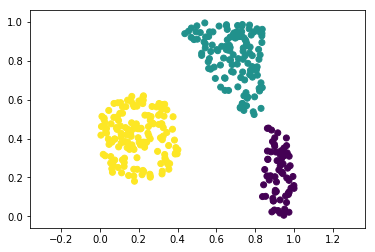

In [88]:
data = np.load('data.npz')
X, y = data['arr_0'], data['arr_1']
plt.scatter(X[:, 0], X[:, 1], c=y)
plt.axis('equal')
plt.show()

Обучите архитектуру вида 2 -> 10 -> 10 -> 3:
* Linear(2, 10)
* Sigmoid()
* Linear(10, 10)
* Sigmoid()
* Linear(10, 3)

В качестве функции потерь используйте NLLLoss.
1. Создайте сеть, в цикле запускайте forward, backward, step (используйте learning rate 0.005). 
2. Нарисуйте график сходимости (величина NLL после каждого обновления).
3. Нарисуйте разделяющую поверхность
4. Попробуйте подобрать темп обучения. Как меняется сходимость?

In [89]:
### YOUR CODE HERE:
# nn = NeuralNetwork([
#     Linear(2, 10),
#     Sigmoid(),
#     Linear(10, 10),
#     Sigmoid(),
#     Linear(10, 3),
# ])

nn = NeuralNetwork([
    Linear(2, 3),
])


# print(X)
# print(y)
nll = NLLLoss()
losses = []
for i in range(80):
    y_ = nn.forward(X)
    loss = nll.forward(y_, y)
    if i % 1 == 0:
        losses.append(loss)
        print(i, ': ', loss)
    dLdy = nll.backward()
    nn.backward(dLdy)
    nn.step(2e-2)

0 :  383.653448643
1 :  352.228582958
2 :  359.896507566
3 :  577.464550389
4 :  639.796137615
5 :  320.825015254
6 :  322.110327903
7 :  326.168292803
8 :  295.137849503
9 :  210.059955037
10 :  139.822074724
11 :  100.820369402
12 :  60.28262794
13 :  48.6198751086
14 :  44.4750964306
15 :  42.7533268651
16 :  41.4058367858
17 :  40.1831208015
18 :  39.0474031556
19 :  37.987508929
20 :  36.9956179279
21 :  36.0650814803
22 :  35.1901134826
23 :  34.3656482731
24 :  33.5872303454
25 :  32.8509241361
26 :  32.1532394642
27 :  31.4910695344
28 :  30.8616390895
29 :  30.2624608156
30 :  29.6912985001
31 :  29.1461357473
32 :  28.6251492926
33 :  28.1266861412
34 :  27.6492439042
35 :  27.1914538185
36 :  26.7520660322
37 :  26.3299368066
38 :  25.92401735
39 :  25.5333440428
40 :  25.1570298563
41 :  24.7942567958
42 :  24.4442692292
43 :  24.1063679799
44 :  23.7799050847
45 :  23.4642791297
46 :  23.1589310907
47 :  22.8633406159
48 :  22.5770226956
49 :  22.2995246739
50 :  22.030423

In [98]:
y_ = nn.forward(X)
np.argmax(y_, axis=1) == y

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

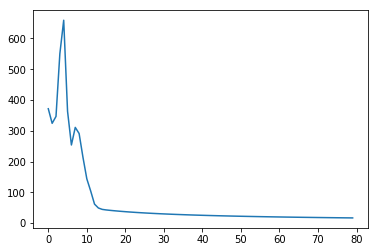

In [73]:
plt.plot(range(0, len(losses)), losses)

Отличная визуализация: http://playground.tensorflow.org/

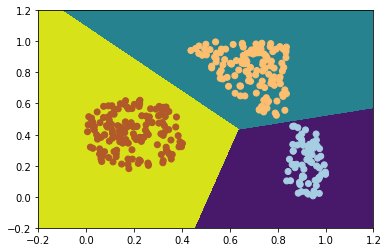

In [75]:
### YOUR CODE HERE:
h = 0.001
x_min, x_max = -0.2, 1.2
y_min, y_max = -0.2, 1.2
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))


# here "model" is your model's prediction (classification) function
xr = xx.ravel()
yr = yy.ravel()
xy = np.vstack((xr, yr)).T

y_ = np.argmax(nn.forward(xy), axis=1)

# Put the result into a color plot
y_ = y_.reshape(xx.shape)
plt.contourf(xx, yy, y_)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=pl.cm.Paired)
# plt.show()